In [1]:
#https://github.com/TommasoStrada/Progetto-Data-Science-Lab

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

In [2]:
#!pip install xgboost 1.6

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost

In [4]:
shift_giornaliero = 1       #giorno precedente
shift_settimanale = 7       #stesso giorno, settimana precedente
shift_mensile = 28          #stesso giorno, circa mese precedente
shift_annuale = 364         #stesso giorno, circa anno precedente

shift_scelto = shift_giornaliero

In [5]:
print("xgboost versione numero: ", xgboost.__version__)

xgboost versione numero:  0.90


In [6]:
repo_alessandro = "https://github.com/Alessandro-Fasani/DsLab/raw/main/serie-storiche-ecommerce-pulito-no-buchi-temporali.csv"
repo_team = ""

In [7]:
ds = pd.read_csv(repo_alessandro)

#**Esplorazione e pulizia Dataset**

In [8]:
ds.sample(5)

,Unnamed: 0,data,new_index,totale,settore,Anno,Mese,Giorno,Mese (n°)
3557,3557,2015-06-11,4078.0,12854.68,Calcio,2015,Giugno,11,6
10289,10289,2017-04-11,10057.0,810.51,Fitness,2017,Aprile,11,4
14608,14608,2020-10-20,20809.0,4393.42,Running,2020,Ottobre,20,10
5499,5499,2020-10-04,20666.0,43861.31,Calcio,2020,Ottobre,4,10
943,943,2016-08-01,7896.0,32548.78,Pesca,2016,Agosto,1,8


In [9]:
ds = ds[["data", "settore", "totale"]]
ds.dtypes

data        object
settore     object
totale     float64
dtype: object

In [10]:
#Sistemiamo i tipi
ds["settore"] = ds.settore.astype("category")
ds['data'] = pd.to_datetime(ds['data'])
ds.dtypes

data       datetime64[ns]
settore          category
totale            float64
dtype: object

In [11]:
ds.settore.unique()

['Pesca', 'Calcio', 'Casual', 'Fitness', 'Running']
Categories (5, object): ['Calcio', 'Casual', 'Fitness', 'Pesca', 'Running']

In [12]:
ds.sample(5)

,data,settore,totale
9357,2014-09-22,Fitness,16179.67
573,2015-07-28,Pesca,6683.05
11761,2021-04-22,Fitness,13082.55
12940,2016-03-27,Running,3984.34
593,2015-08-17,Pesca,15550.39


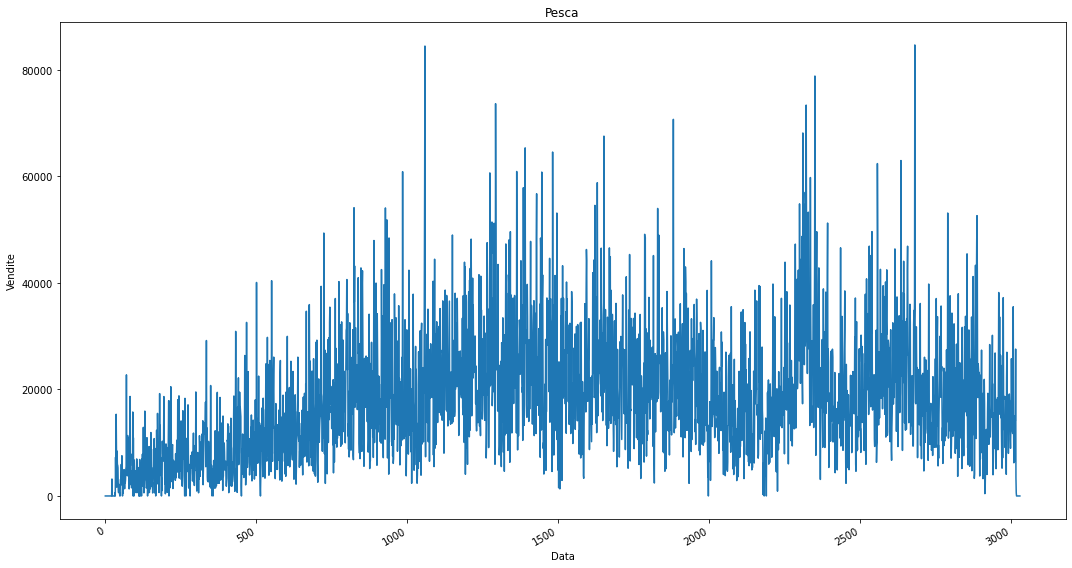

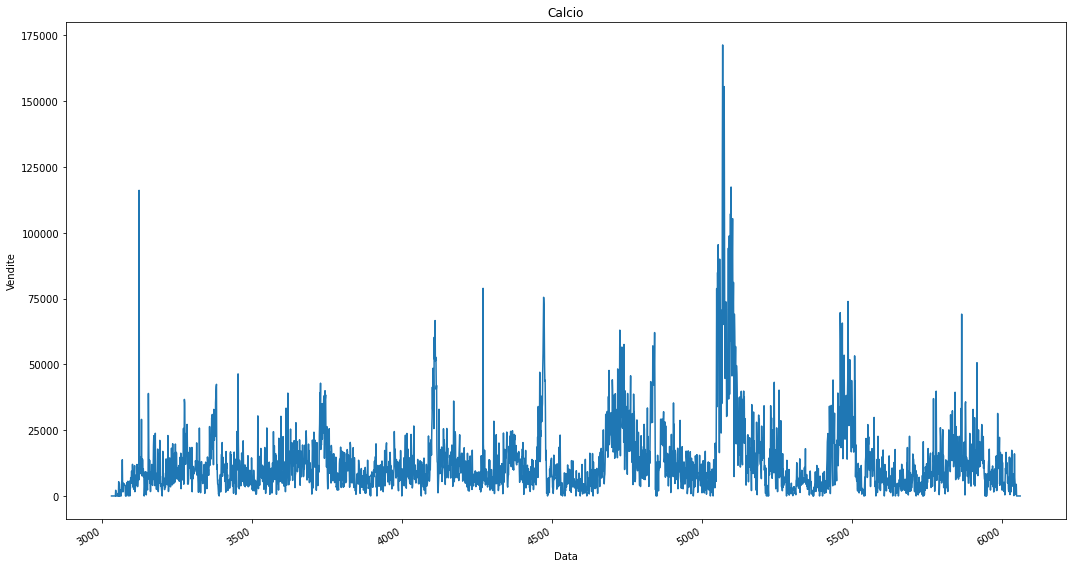

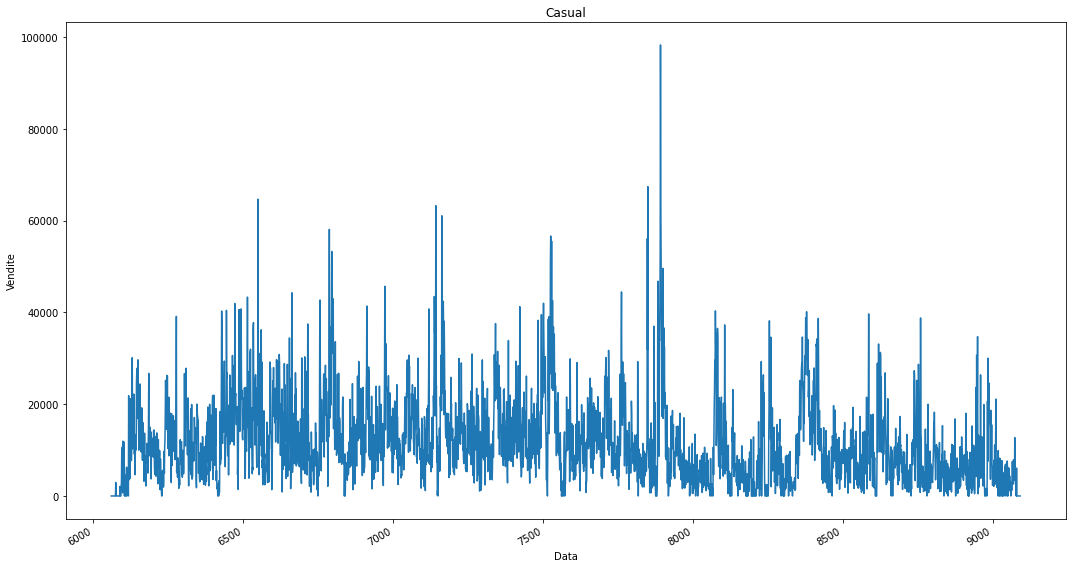

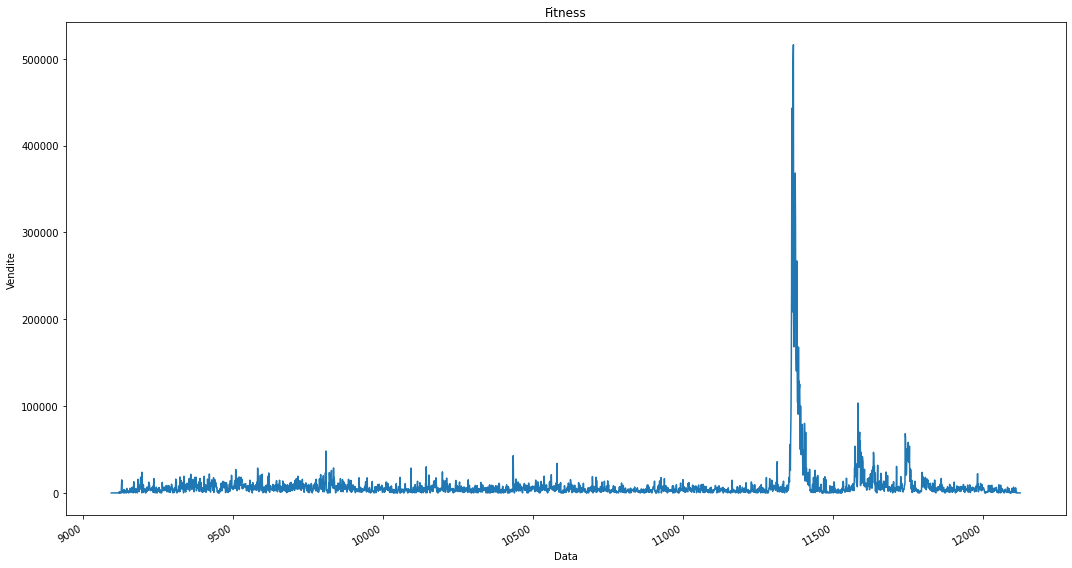

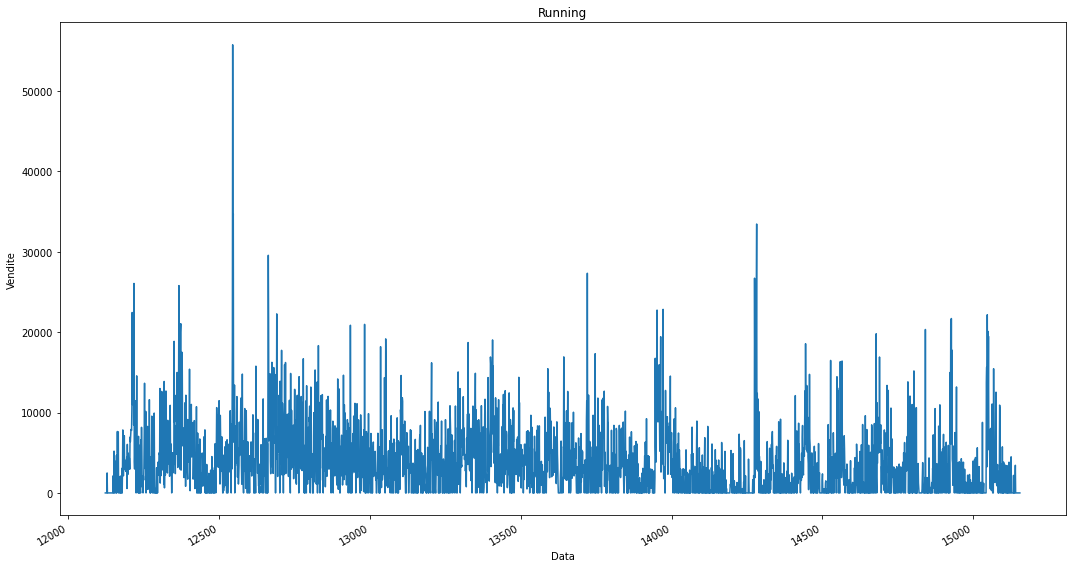

In [13]:
for categorie in ds.settore.unique():
  fig, ax = plt.subplots(figsize=(15, 8))
  ax.plot(ds[ds["settore"]==categorie]['totale'])
  ax.set_title(categorie)
  ax.set_xlabel('Data')
  ax.set_ylabel('Vendite')

  fig.autofmt_xdate()
  plt.tight_layout()
  plt.show()

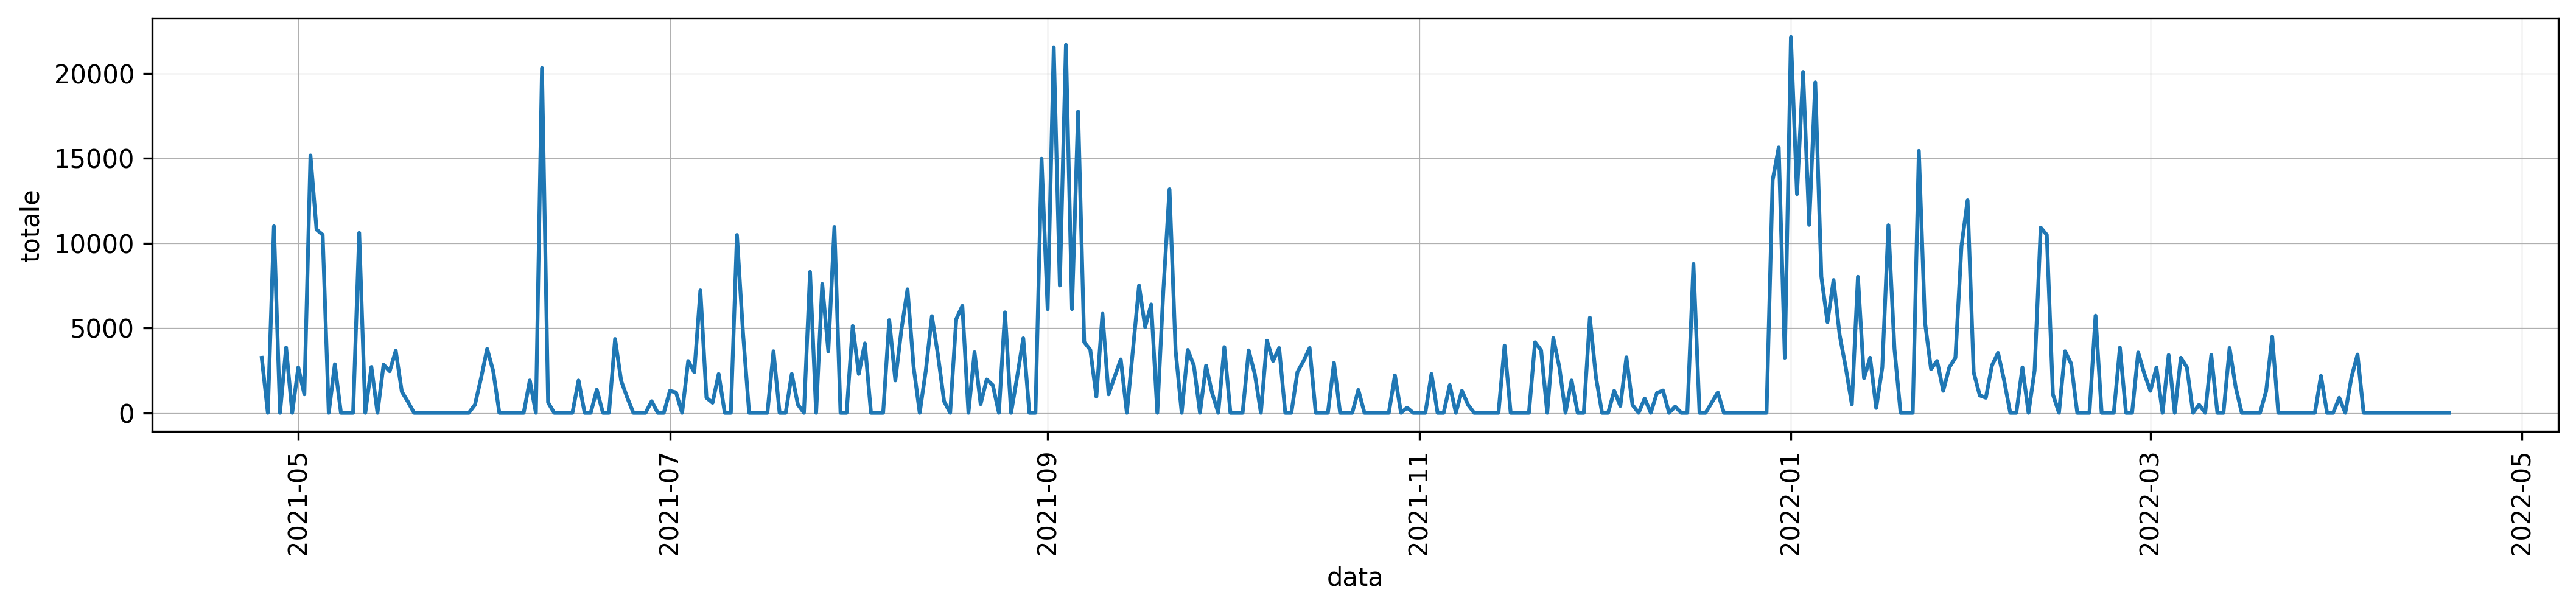

In [14]:
#IN ALTERNATIVA (ds[ds["settore"]==categorie]['totale']) <--NON funziona l'iterazione;settare un settore alla volta 
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds.tail(360), x='data', y='totale')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [15]:
#for categorie in ds.settore.unique():
#    
#    #Andamento annuale delle vendite per ogni settore sportivo
#    dv = ds[ds['settore'] == categorie].groupby(['Anno'], as_index = False).sum()[['Anno', 'totale']] #Visualizziamo solo queste in un dataframe nuovo
#
#    #Corpo della visualizzazione
#    plt.figure(figsize=(12,5))
#    x = dv['Anno'].to_list()
#    y = dv['totale'].to_list()
#
#    # Parte Estetica 
#    plt.xticks(x)
#    # plt.yticks(range(0,366,30))
#    plt.xlabel('Anni')
#    plt.ylabel('Totale Vendite')
#    plt.plot(x, y)
#    plt.title('Frequenze settore {} per anno'.format(categorie))
#    
#    # Mostra valori esatti del totale vendite per ogni osservazione (per ogni anno)
#    for i,j in zip(x,y):
#        plt.annotate(str(j),xy=(i,j))

#**Osservazioni sulle vendite giornaliere di prodotti dei settori Calcio, Pesca e Casual**


In [16]:
ds_calcio = ds[ds["settore"]== "Calcio"]
ds_pesca = ds[ds["settore"]== "Pesca"]
ds_casual =ds[ds["settore"]== "Casual"]

In [17]:
porzione_test = round(len(ds_calcio) * 0.2)       # 20% circa verra usato per il test 
porzione_test

606

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


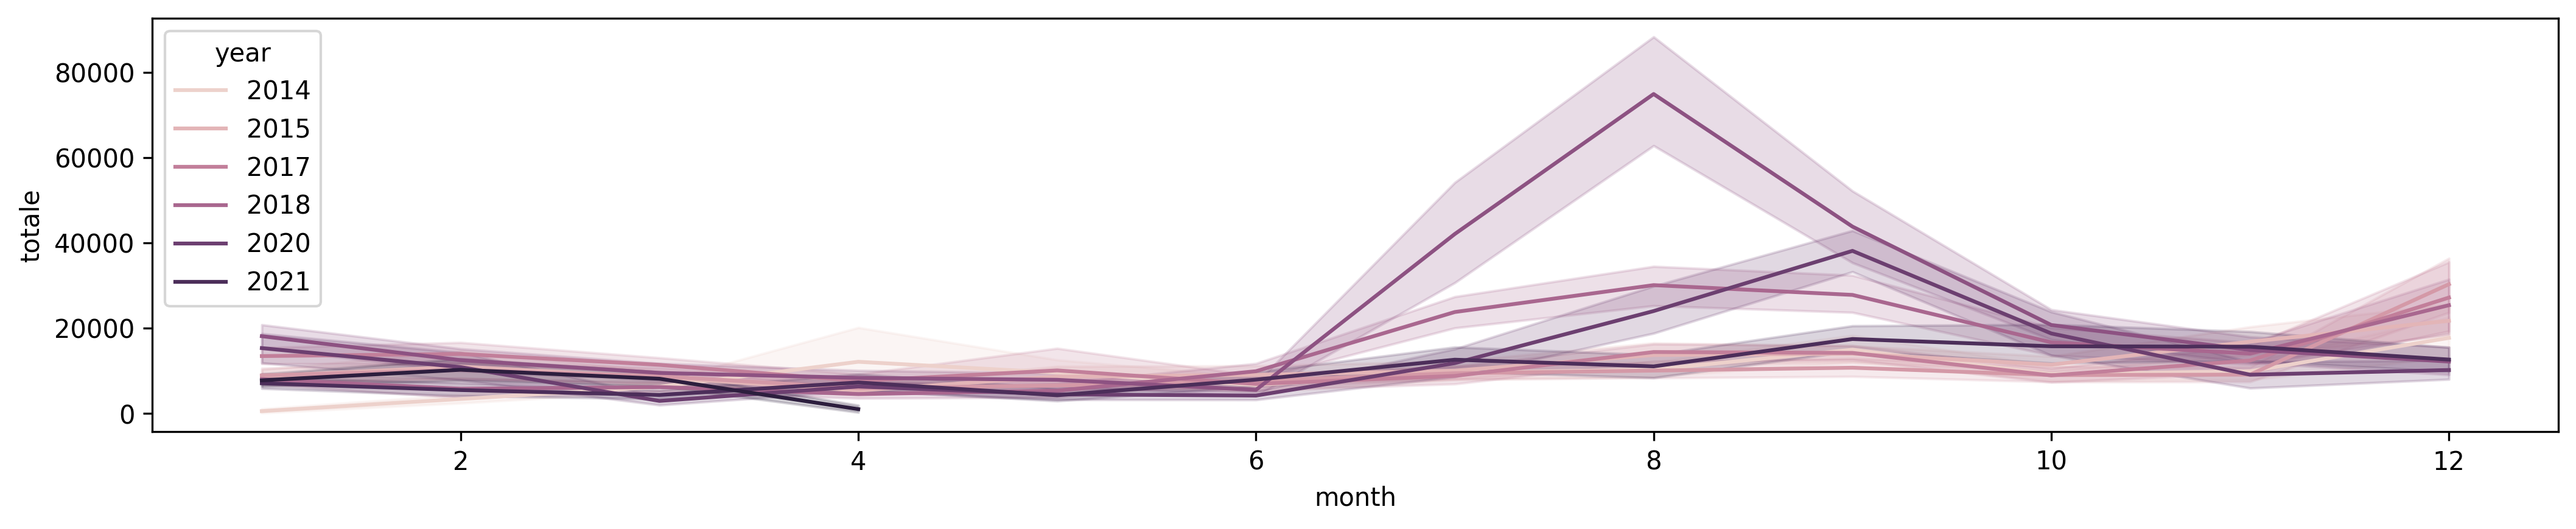

In [18]:
ds_calcio['month'] = ds_calcio['data'].dt.month
ds_calcio['year'] = ds_calcio['data'].dt.year
sns.lineplot(x= ds_calcio['month'], y= ds_calcio['totale'], hue=ds_calcio['year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


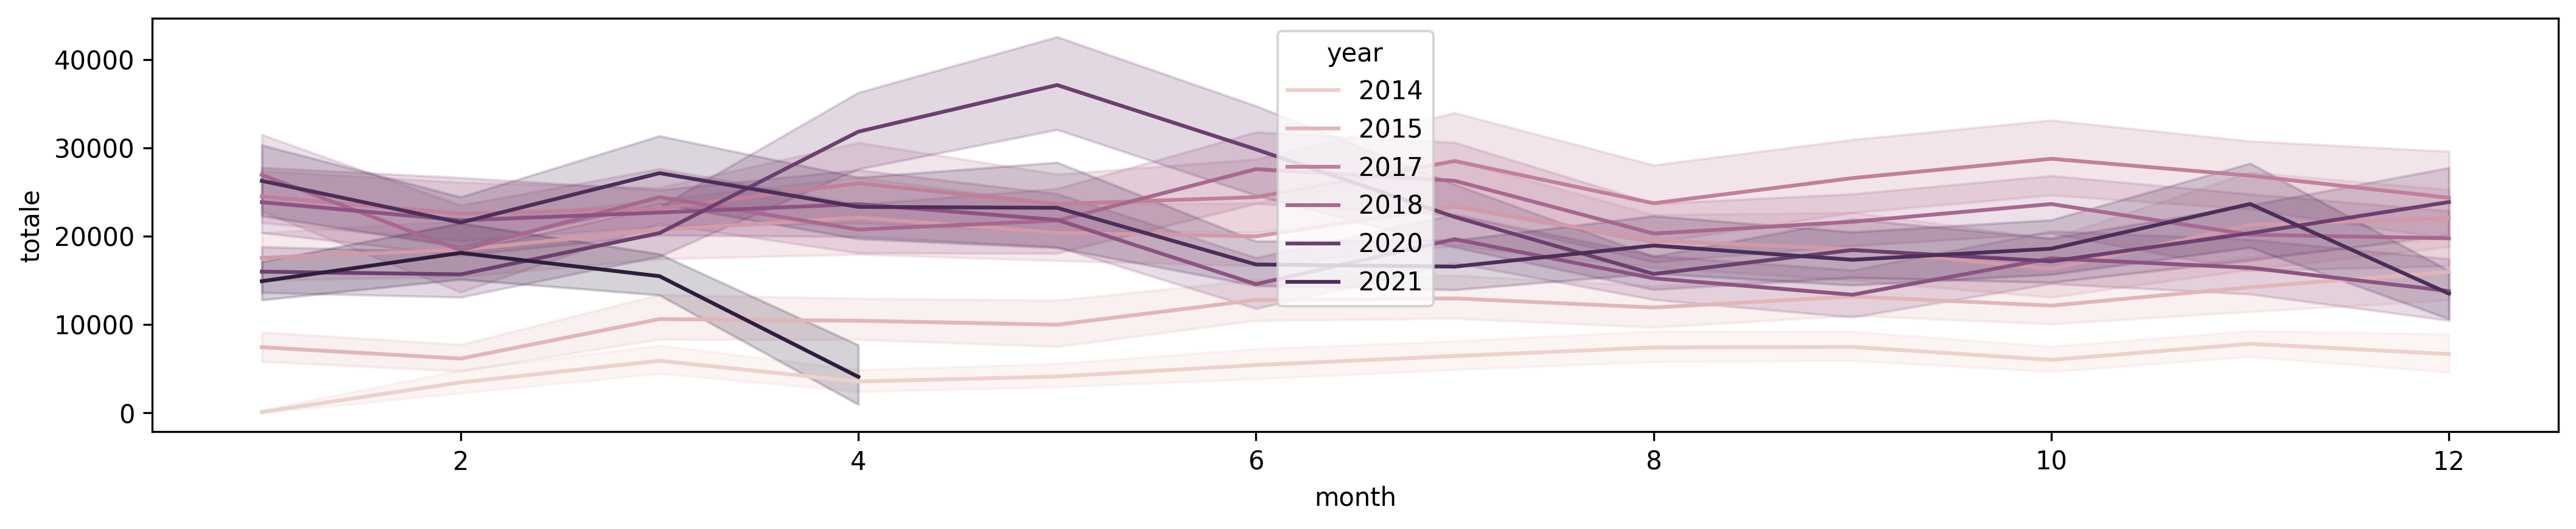

In [19]:
ds_pesca['month'] = ds_pesca['data'].dt.month
ds_pesca['year'] = ds_pesca['data'].dt.year
sns.lineplot(x= ds_pesca['month'], y= ds_pesca['totale'], hue=ds_pesca['year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


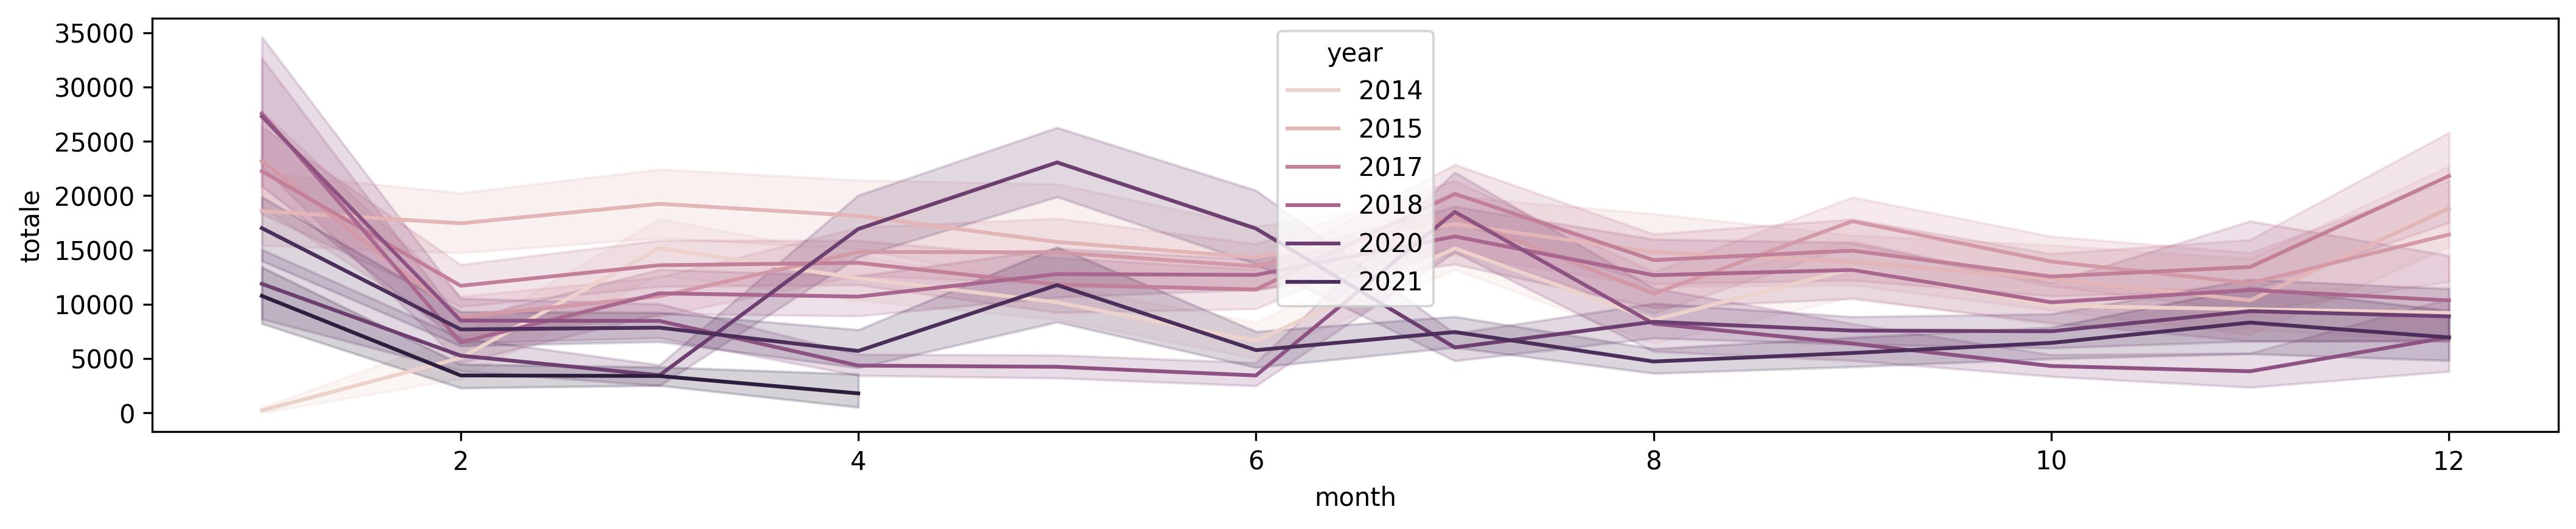

In [20]:
ds_casual['month'] = ds_casual['data'].dt.month
ds_casual['year'] = ds_casual['data'].dt.year
sns.lineplot(x= ds_casual['month'], y= ds_casual['totale'], hue=ds_casual['year'])

In [21]:
ds_calcio["totale_periodo_prec"] = ds_calcio["totale"].shift(+shift_scelto)
ds_pesca["totale_periodo_prec"] = ds_pesca["totale"].shift(+shift_scelto)
ds_casual["totale_periodo_prec"] = ds_casual["totale"].shift(+shift_scelto)

ds_calcio= ds_calcio.dropna()    
ds_pesca= ds_pesca.dropna()      
ds_casual= ds_casual.dropna()    

ds_calcio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,data,settore,totale,month,year,totale_periodo_prec
3032,2014-01-02,Calcio,0.0,1,2014,0.0
3033,2014-01-03,Calcio,0.0,1,2014,0.0
3034,2014-01-04,Calcio,0.0,1,2014,0.0
3035,2014-01-05,Calcio,0.0,1,2014,0.0
3036,2014-01-06,Calcio,0.0,1,2014,0.0
...,...,...,...,...,...,...
6057,2022-04-15,Calcio,0.0,4,2022,0.0
6058,2022-04-16,Calcio,0.0,4,2022,0.0
6059,2022-04-17,Calcio,0.0,4,2022,0.0
6060,2022-04-18,Calcio,0.0,4,2022,0.0


In [22]:
#LIST INPUT, divisione tra parte train e parte dedicata al test
x_calcio = ds_calcio[['totale_periodo_prec']]
x_pesca = ds_pesca[['totale_periodo_prec']]
x_casual = ds_casual[['totale_periodo_prec']]

x_calcio_to_train = x_calcio.iloc[:(len(x_calcio)-porzione_test)]
x_pesca_to_train = x_pesca.iloc[:(len(x_pesca)-porzione_test)]
x_casual_to_train = x_casual.iloc[:(len(x_casual)-porzione_test)]

x_calcio_to_test = x_calcio.iloc[(len(x_calcio)-porzione_test):]
x_pesca_to_test = x_pesca.iloc[(len(x_pesca)-porzione_test):]
x_casual_to_test = x_casual.iloc[(len(x_casual)-porzione_test):]


#LIST OUTPUT, divisione tra parte train e parte dedicata al test
y_calcio = ds_calcio[['totale']]
y_pesca = ds_pesca[['totale']]
y_casual = ds_casual[['totale']]

y_calcio_to_train = y_calcio.iloc[:(len(y_calcio)-porzione_test)]
y_pesca_to_train = y_pesca.iloc[:(len(y_pesca)-porzione_test)]
y_casual_to_train = y_casual.iloc[:(len(y_casual)-porzione_test)]

y_calcio_to_test = y_calcio.iloc[(len(y_calcio)-porzione_test):]
y_pesca_to_test = y_pesca.iloc[(len(y_pesca)-porzione_test):]
y_casual_to_test = y_casual.iloc[(len(y_casual)-porzione_test):]

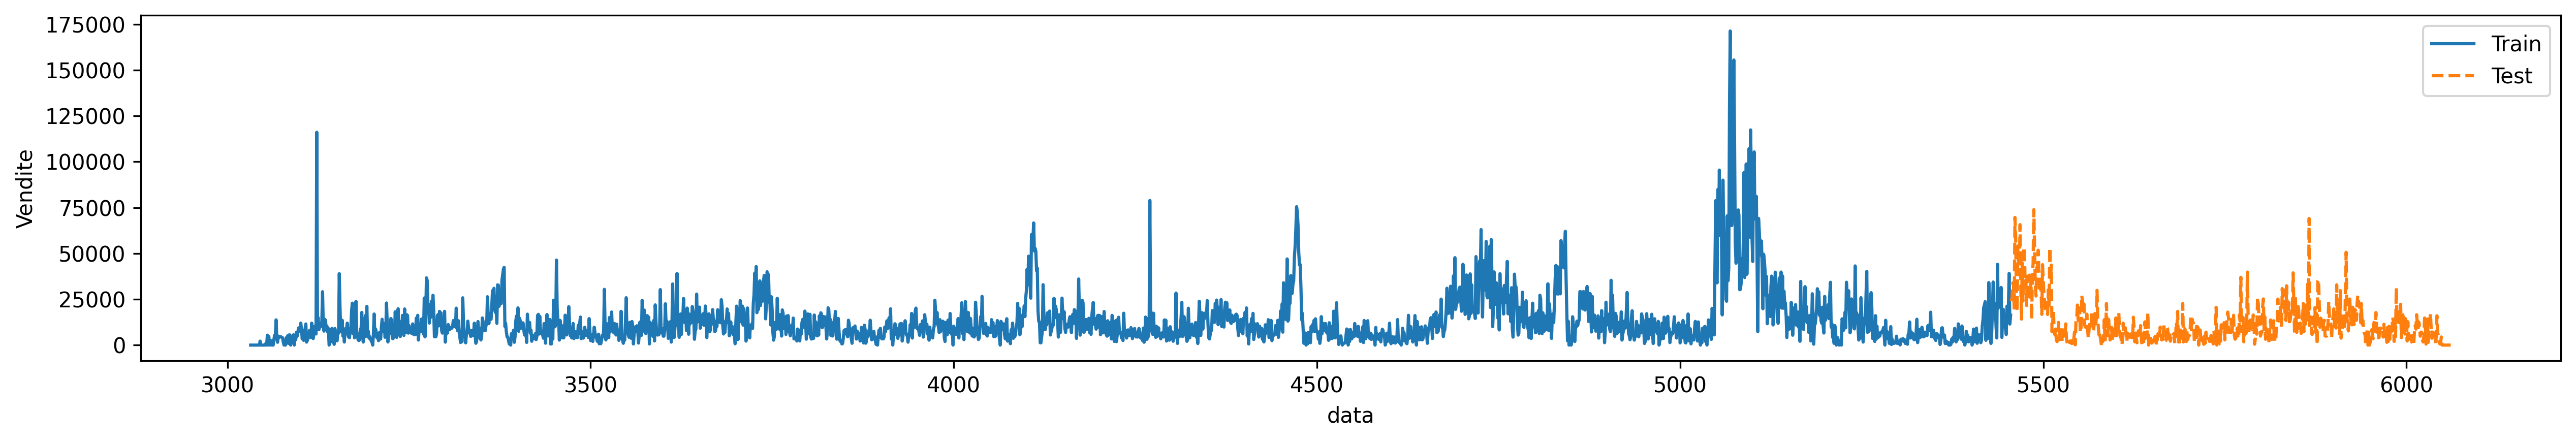

In [23]:

fig, ax = plt.subplots(figsize=(17, 3))
ax.plot(y_calcio_to_train, ls='-', label='Train')
ax.plot(y_calcio_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
estimator_calcio = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.01)
estimator_pesca = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.01)
estimator_casual = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.01)

estimator_calcio.fit(x_calcio_to_train, y_calcio_to_train,
              eval_set=[(x_calcio_to_train, y_calcio_to_train), (x_calcio_to_test, y_calcio_to_test)],
              eval_metric='mae')

estimator_pesca.fit(x_pesca_to_train, y_pesca_to_train,
              eval_set=[(x_pesca_to_train, y_pesca_to_train), (x_pesca_to_test, y_pesca_to_test)],
              eval_metric='mae')

estimator_casual.fit(x_casual_to_train, y_casual_to_train,
              eval_set=[(x_casual_to_train, y_casual_to_train), (x_casual_to_test, y_casual_to_test)],
              eval_metric='mae')

[0]	validation_0-mae:13003.4	validation_1-mae:11744.3
[1]	validation_0-mae:12877.8	validation_1-mae:11629.5
[2]	validation_0-mae:12753.5	validation_1-mae:11516.5
[3]	validation_0-mae:12630.4	validation_1-mae:11404.8
[4]	validation_0-mae:12508.7	validation_1-mae:11294.9
[5]	validation_0-mae:12388.3	validation_1-mae:11187.5
[6]	validation_0-mae:12269.6	validation_1-mae:11081.7
[7]	validation_0-mae:12152.2	validation_1-mae:10976.2
[8]	validation_0-mae:12036.2	validation_1-mae:10872.5
[9]	validation_0-mae:11921.8	validation_1-mae:10769.9
[10]	validation_0-mae:11809	validation_1-mae:10669.7
[11]	validation_0-mae:11697.5	validation_1-mae:10569.9
[12]	validation_0-mae:11587.5	validation_1-mae:10472.3
[13]	validation_0-mae:11479.1	validation_1-mae:10375.8
[14]	validation_0-mae:11372.1	validation_1-mae:10279.6
[15]	validation_0-mae:11266.6	validation_1-mae:10186
[16]	validation_0-mae:11162.8	validation_1-mae:10093.7
[17]	validation_0-mae:11060.5	validation_1-mae:10004
[18]	validation_0-mae:1095

XGBRegressor(learning_rate=0.01, n_estimators=150, objective='reg:squarederror')

In [25]:
predictions_calcio = estimator_calcio.predict(x_calcio_to_test)
predictions_pesca = estimator_pesca.predict(x_pesca_to_test)
predictions_casual = estimator_casual.predict(x_casual_to_test)

In [26]:
calcio_evalutation_ds = ds_calcio[(len(ds_calcio)-porzione_test):]   
calcio_evalutation_ds = calcio_evalutation_ds.reset_index().drop('index', axis=1)
calcio_evalutation_ds['predictions'] = pd.Series(predictions_calcio)
calcio_evalutation_ds

,data,settore,totale,month,year,totale_periodo_prec,predictions
0,2020-08-22,Calcio,23952.71,8,2020,16265.39,10116.048828
1,2020-08-23,Calcio,26119.53,8,2020,23952.71,16803.906250
2,2020-08-24,Calcio,33946.58,8,2020,26119.53,16803.906250
3,2020-08-25,Calcio,33707.52,8,2020,33946.58,21607.968750
4,2020-08-26,Calcio,19287.48,8,2020,33707.52,21607.968750
...,...,...,...,...,...,...,...
601,2022-04-15,Calcio,0.00,4,2022,0.00,3889.630127
602,2022-04-16,Calcio,0.00,4,2022,0.00,3889.630127
603,2022-04-17,Calcio,0.00,4,2022,0.00,3889.630127
604,2022-04-18,Calcio,0.00,4,2022,0.00,3889.630127


In [27]:
pesca_evalutation_ds = ds_pesca[(len(ds_pesca)-porzione_test):]  
pesca_evalutation_ds = pesca_evalutation_ds.reset_index().drop('index', axis=1)
pesca_evalutation_ds['predictions'] = pd.Series(predictions_pesca)
pesca_evalutation_ds

,data,settore,totale,month,year,totale_periodo_prec,predictions
0,2020-08-22,Pesca,4893.37,8,2020,15397.02,14283.870117
1,2020-08-23,Pesca,16219.81,8,2020,4893.37,7700.466309
2,2020-08-24,Pesca,15856.31,8,2020,16219.81,14783.295898
3,2020-08-25,Pesca,17685.01,8,2020,15856.31,14283.870117
4,2020-08-26,Pesca,17508.99,8,2020,17685.01,15045.422852
...,...,...,...,...,...,...,...
601,2022-04-15,Pesca,0.00,4,2022,0.00,2544.347900
602,2022-04-16,Pesca,0.00,4,2022,0.00,2544.347900
603,2022-04-17,Pesca,0.00,4,2022,0.00,2544.347900
604,2022-04-18,Pesca,0.00,4,2022,0.00,2544.347900


In [28]:
casual_evalutation_ds = ds_casual[(len(ds_casual)-porzione_test):]  
casual_evalutation_ds = casual_evalutation_ds.reset_index().drop('index', axis=1)
casual_evalutation_ds['predictions'] = pd.Series(predictions_casual)
casual_evalutation_ds

,data,settore,totale,month,year,totale_periodo_prec,predictions
0,2020-08-22,Casual,4419.89,8,2020,10918.18,9578.472656
1,2020-08-23,Casual,12735.15,8,2020,4419.89,5696.694336
2,2020-08-24,Casual,4582.81,8,2020,12735.15,10056.906250
3,2020-08-25,Casual,1472.02,8,2020,4582.81,6005.417480
4,2020-08-26,Casual,4528.50,8,2020,1472.02,4530.390625
...,...,...,...,...,...,...,...
601,2022-04-15,Casual,0.00,4,2022,0.00,2023.581909
602,2022-04-16,Casual,0.00,4,2022,0.00,2023.581909
603,2022-04-17,Casual,0.00,4,2022,0.00,2023.581909
604,2022-04-18,Casual,0.00,4,2022,0.00,2023.581909


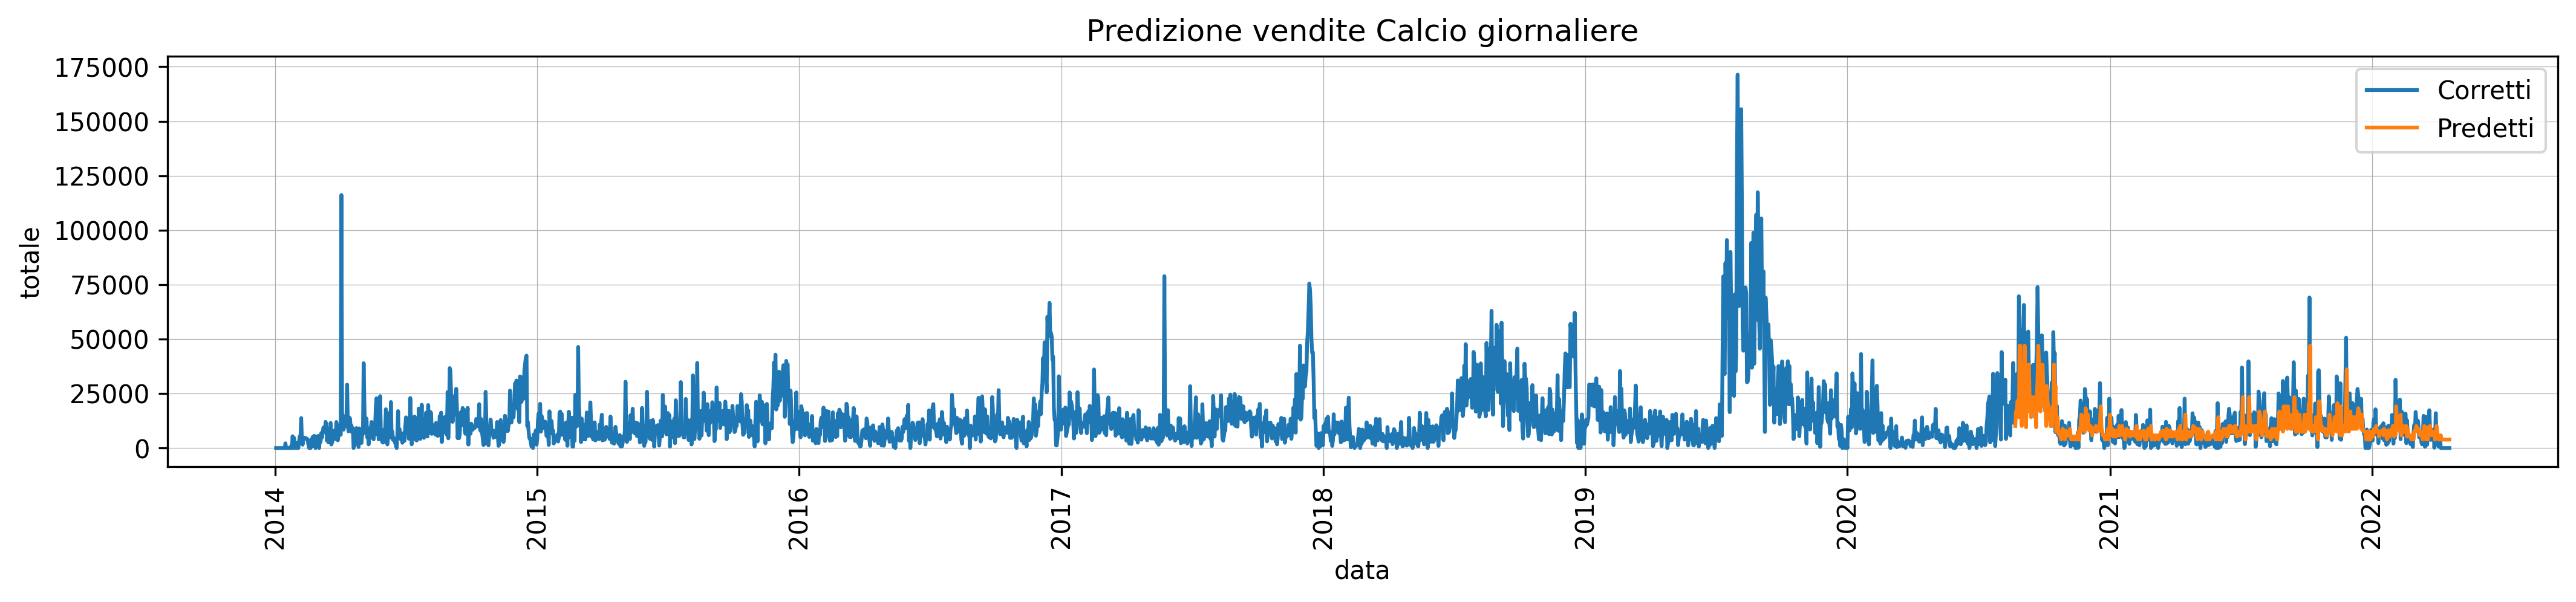

In [29]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x= "data", y='totale', label= "Corretti" )     #_evalutation
sns.lineplot(data=calcio_evalutation_ds, x='data', y='predictions', palette= "red",  label= "Predetti")

#x = calcio_evalutation_ds['year']  
#y = calcio_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = calcio_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  calcio_evalutation_ds

plt.title("Predizione vendite Calcio giornaliere")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

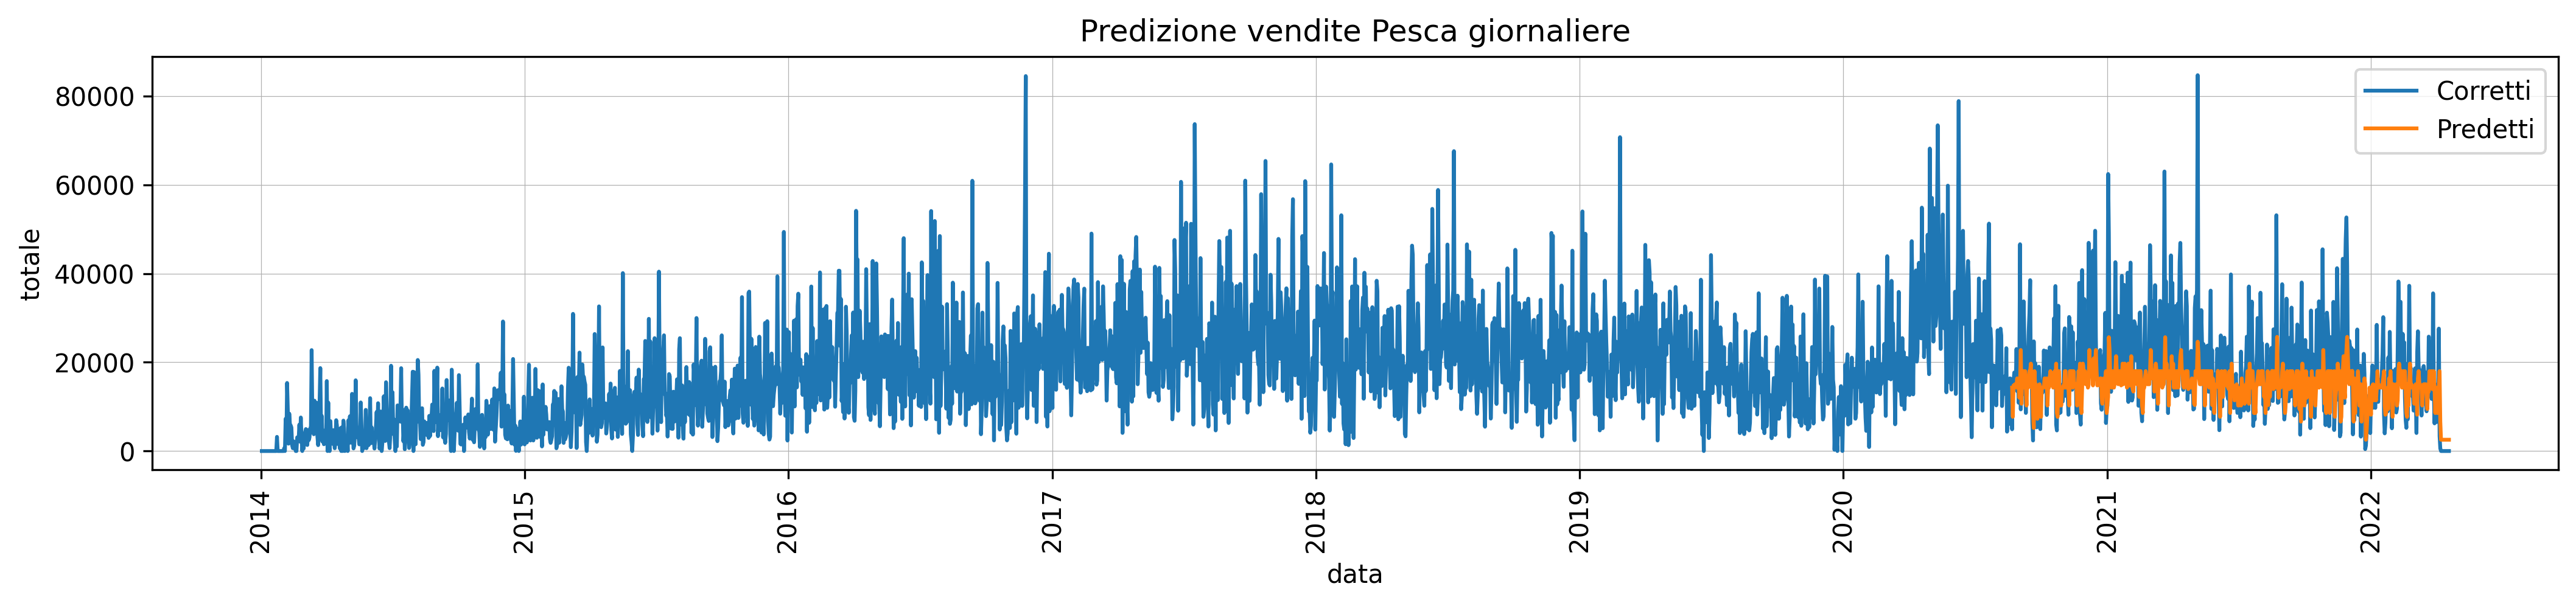

In [30]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x= "data", y='totale', label= "Corretti")     
sns.lineplot(data=pesca_evalutation_ds, x='data', y='predictions', palette= "red", label= "Predetti") 

#x = pesca_evalutation_ds['year']  
#y = pesca_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = pesca_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  pesca_evalutation_ds

plt.title("Predizione vendite Pesca giornaliere")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

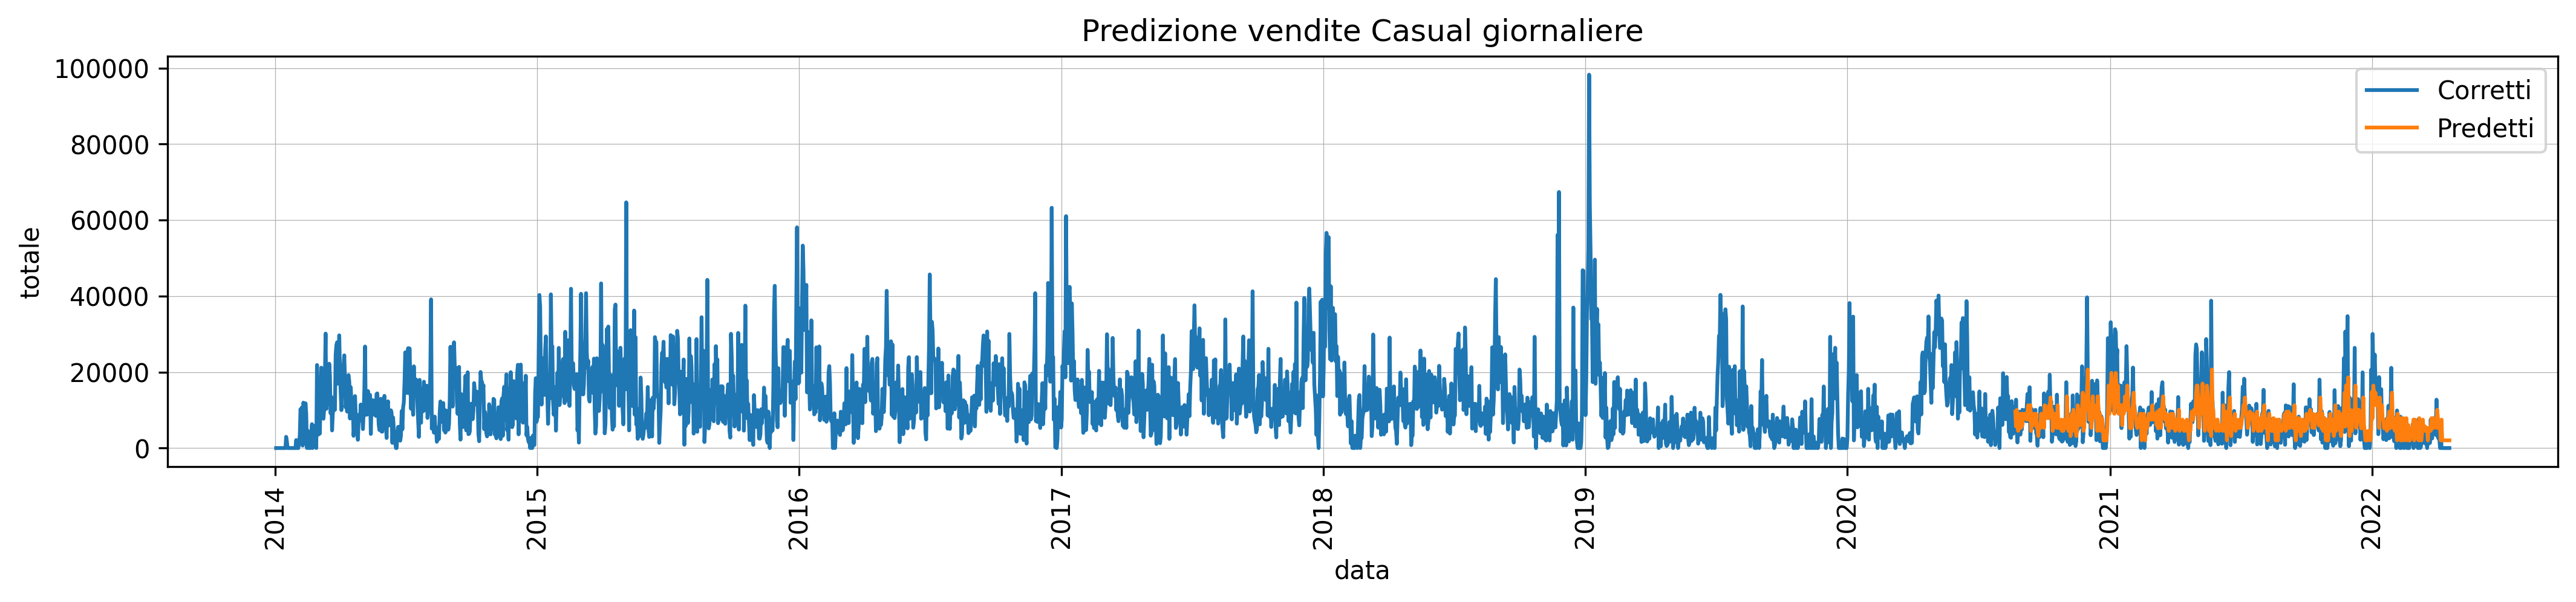

In [31]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x= "data", y='totale', label= "Corretti")     
sns.lineplot(data=casual_evalutation_ds, x='data', y='predictions', palette= "red", label= "Predetti") 

#x = casual_evalutation_ds['year']  
#y = casual_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = casual_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  casual_evalutation_ds

plt.title("Predizione vendite Casual giornaliere")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [32]:
print('Calcio XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(calcio_evalutation_ds["totale"] - calcio_evalutation_ds["predictions"])))

Calcio XgBoost Mean Absolute Error (MAE):  6075.912374948432


In [33]:
print('Pesca XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(pesca_evalutation_ds["totale"] - pesca_evalutation_ds["predictions"])))

Pesca XgBoost Mean Absolute Error (MAE):  7631.582810743476


In [34]:
print('Casual XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(casual_evalutation_ds["totale"] - casual_evalutation_ds["predictions"])))

Casual XgBoost Mean Absolute Error (MAE):  4286.313418468311


In [35]:
MAEoneDayCalcio = 6075.912374948432
MAEoneDayPesca = 7631.582810743476
MAEoneDayCasual = 4286.313418468311

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
print('Seasonality error reduction: ', (((np.mean(np.abs(calcio_evalutation_ds["totale"] - calcio_evalutation_ds["predictions"])))/MAEoneDayCalcio)-1)*100    )

Seasonality error reduction:  0.0


In [38]:
print('Seasonality error reduction: ', (((np.mean(np.abs(pesca_evalutation_ds["totale"] - pesca_evalutation_ds["predictions"])))/MAEoneDayPesca)-1)*100     )

Seasonality error reduction:  0.0


In [39]:
print('Seasonality error reduction: ', (((np.mean(np.abs(casual_evalutation_ds["totale"] - casual_evalutation_ds["predictions"])))/MAEoneDayCasual)-1)*100     )

Seasonality error reduction:  0.0


(150 estimator si adatta bene a tutti i dataset con shift giornaliero)
(Calcio migliore intorno ai 170)
(Pesca migliore intorno ai 240)
(Casual migliore intorno ai 150)




Con shift +1 giorno

* Calcio XgBoost Mean Absolute Error (MAE):  6075.912374948432
* Pesca XgBoost Mean Absolute Error (MAE):  7631.582810743476
* Casual XgBoost Mean Absolute Error (MAE):  4286.313418468311



Con shift +7 giorni

* Calcio XgBoost Mean Absolute Error (MAE):  6720.503515625
* Pesca XgBoost Mean Absolute Error (MAE):  7916.815223126804
* Casual XgBoost Mean Absolute Error (MAE):  4884.174129215656


* Calcio Seasonality error reduction: + 10.61 %
* Pesca Seasonality error reduction: + 3.74 % 
* Casual Seasonality error reduction: + 13.95 %



Con shift +28 giorni

* Calcio XgBoost Mean Absolute Error (MAE):  7533.19374858189
* Pesca XgBoost Mean Absolute Error (MAE):  8009.064683439045
* Casual XgBoost Mean Absolute Error (MAE):  5504.057526460653


* Calcio Seasonality error reduction:  + 23.98 %
* Pesca Seasonality error reduction:  + 4.94 % 
* Casual Seasonality error reduction:  + 28.41 %




Con shift +364 giorni

* Calcio XgBoost Mean Absolute Error (MAE):  7325.24470119766
* Pesca XgBoost Mean Absolute Error (MAE):  7971.969267868194
* Casual XgBoost Mean Absolute Error (MAE):  5492.122330729167


* Calcio Seasonality error reduction:  + 20.56 %
* Pesca Seasonality error reduction:  + 4.46 % 
* Casual Seasonality error reduction:  + 28.13 %

Ogni tentativo di introdurre stagionalità ha portato ad un peggiormaneto delle predizioni rispetto al MAE dello Shift giornaliero